Let's implement a 3-layer neural network manually to make sure I understand basic NN architecture

This notebook uses LeCun et al's MNIST database of handwritten digits to train and test a 3-layer fully connected neural network, without using PyTorch or TensorFlow.

Verify dataset exists or download it:

In [1]:
import os
import requests

datasets = {
    'training set images': 'train-images-idx3-ubyte.gz',
    'training set labels': 'train-labels-idx1-ubyte.gz',
    'test set images': 't10k-images-idx3-ubyte.gz',
    'test set labels': 't10k-labels-idx1-ubyte.gz',
}
remote_path = 'http://yann.lecun.com/exdb/mnist/'
remote_path = 'https://cseweb.ucsd.edu/~weijian/static/datasets/mnist/' # lecun's site gives http error 403 (2024/05/26)
local_path = 'datasets'

if not os.path.exists(local_path):
    os.mkdir(local_path)

for dataset_name, filename in datasets.items():
    local_file = os.path.join(local_path, filename)
    if os.path.exists(local_file):
        print(f'{dataset_name} ({local_file}) exists')
    else:
        print(f'Downloading {dataset_name} from {remote_path + filename}')
        response = requests.get(remote_path + filename)
        response.raise_for_status()
        # Open file in write-binary mode, write response content to it:
        with open(local_file, 'wb') as file:
            file.write(response.content)
            print(f"{dataset_name} saved to {local_file}")


training set images saved to datasets/train-images-idx3-ubyte.gz
training set labels saved to datasets/train-labels-idx1-ubyte.gz
test set images saved to datasets/t10k-images-idx3-ubyte.gz
test set labels saved to datasets/t10k-labels-idx1-ubyte.gz


Load the training data.

Format spec:

<small><pre>
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label (values 0 to 9)
........
xxxx     unsigned byte   ??               label

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel (organized row-wise, values 0..255, 0 means background, 255 means foreground)
........
xxxx     unsigned byte   ??               pixel
</pre></small>

In [2]:
import gzip
import struct
import numpy as np

label_file = local_path + '/' + datasets['training set labels']
image_file = local_path + '/' + datasets['training set images']

def check_data(label_file:str, image_file:str):
    '''check if data files look valid and have the same number of records'''
    with gzip.open(label_file, 'rb') as gz_labels:
        labels_data_header = gz_labels.read(8)
        labels_magic_num = struct.unpack('>i', labels_data_header[0:4])[0]
        labels_count = struct.unpack('>i', labels_data_header[4:8])[0]
    with open(label_file, 'rb') as labels:
        # gzip stores the uncompressed size as the last 4 bytes of the file
        labels.seek(-4, 2)
        file_footer = labels.read(4)
        labels_data_size = struct.unpack('<I', file_footer)[0]
    with gzip.open(image_file, 'rb') as gz_images:
        images_data_header = gz_images.read(16)
        images_magic_num = struct.unpack('>i', images_data_header[0:4])[0]
        images_count = struct.unpack('>i', images_data_header[4:8])[0]
        image_format_rows = struct.unpack('>i', images_data_header[8:12])[0]
        image_format_cols = struct.unpack('>i', images_data_header[12:16])[0]
    with open(image_file, 'rb') as images:
        images.seek(-4, 2)
        file_footer = images.read(4)
        images_data_size = struct.unpack('<I', file_footer)[0]

    assert labels_magic_num == 2049 # indicates data is unsigned bytes in 1-dimension
    assert images_magic_num == 2051 # indicates data is unsigned bytes in 3-dimensions
    assert labels_count == images_count
    assert labels_data_size == labels_count + 8
    assert images_data_size == images_count*image_format_rows*image_format_cols + 16

    return(images_count, [image_format_rows, image_format_cols])


(num_records, image_dimensions) = check_data(label_file, image_file)

with gzip.open(label_file, 'rb') as f:
    header_length = 8
    f.seek(header_length)
    buffer = f.read()

    training_labels = np.frombuffer(buffer, dtype=np.uint8)
    del buffer

    print(f'Loaded {len(training_labels)} labels.')

with gzip.open(image_file, 'rb') as f:
    header_length = 16
    f.seek(header_length)
    buffer = f.read()

    training_images = np.frombuffer(buffer, dtype=np.uint8)
    training_images = training_images.reshape(num_records, np.prod(image_dimensions))
    del buffer

    print(f'Loaded {len(training_images)} images with size {image_dimensions}.')

Loaded 60000 labels.
Loaded 60000 images with size [28, 28].


Peek the last image in the set (should be an 8)

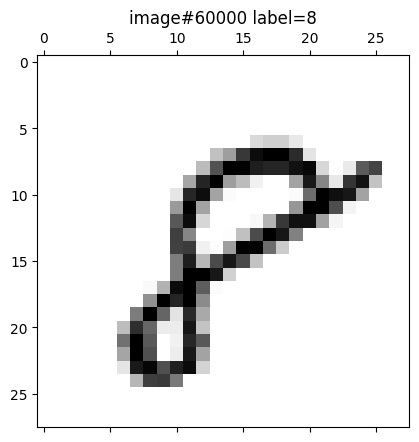

In [3]:
import matplotlib.pyplot as plt

digit = training_images[-1].reshape(image_dimensions)
plt.matshow(digit, cmap='gray_r')   # imshow wrapper for matrix-like data
plt.title(f'image#{num_records} label={training_labels[-1]}')
plt.show()

We have data. Now let's spec out the neural network:

784 inputs (pixel values) --> fc layer 1 (16 nodes) --> fc layer 2 (16 nodes) --> output layer (10 categories)

So: each neuron in layer 1 will have 784 weights plus a bias.

What data structure to use for storing the weights?
 * On the forward pass, we need to take their dot product with incoming signal
 * On backprop, ...

In [4]:
inputs = 784
layer_1_nodes = 16
layer_2_nodes = 16
output_layer_nodes = 10

# initialize our net with small random weights (sampled from uniform distribution)
# todo: does enclosing the ndarrays in a Python list slow access?
#    better idea?: don't use numpy vectors at all; spell out all the computation with vanilla Python
# todo: compare performance if He initiation is used, https://arxiv.org/abs/1502.01852
# todo: make a Layer and Network class
W = [
    np.random.uniform(low=-0.2, high=0.2, size=(layer_1_nodes, inputs)),            # 16 sets of 784 weights (for layer 1)
    np.random.uniform(low=-0.2, high=0.2, size=(layer_2_nodes, layer_1_nodes)),     # 16 sets of 16 weights (for layer 2)
    np.random.uniform(low=-0.2, high=0.2, size=(output_layer_nodes, layer_2_nodes)) # 10 sets of 16 weights (for output layer)
]

with np.printoptions(suppress=True, linewidth=120, edgeitems=4):
    print(np.shape(W[0]))
    print(W[0])

(16, 784)
[[ 0.10050853  0.1234897   0.0619147  -0.16747306 ...  0.18999679 -0.13373601 -0.04873583 -0.19450642]
 [-0.02367538 -0.13258008 -0.09556652 -0.03053395 ... -0.18323824  0.09442131 -0.18116567  0.03835421]
 [-0.01049897  0.03035173 -0.18346946  0.09125276 ...  0.08302591  0.00882349 -0.14647626 -0.17388251]
 [ 0.0401173  -0.0738216   0.05970597 -0.11306976 ...  0.17921072 -0.17165295  0.10606366  0.15465741]
 ...
 [-0.09613696  0.10564533 -0.0861699   0.11706248 ...  0.08082174 -0.14711954 -0.03889234  0.12138033]
 [ 0.15649577  0.08474103 -0.15106879 -0.12564128 ...  0.00082131 -0.10378666  0.13977561 -0.05499227]
 [-0.17630619  0.09459483 -0.05766269 -0.06446186 ... -0.14725138  0.05089891  0.14988666 -0.03737175]
 [ 0.00568958 -0.09328661  0.1780517   0.09297012 ... -0.18982055  0.1991822  -0.08061143  0.13186349]]


In [5]:
# biases start at zero
B = [
    np.zeros(layer_1_nodes),
    np.zeros(layer_2_nodes),
    np.zeros(output_layer_nodes),
]
print(np.shape(B[0]))
B

# todo: we might want these as part of the weight array, to make the processing a single dot product

(16,)


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [6]:
# activation function for hidden layers
def ReLU(X):
    '''rectified linear unit function, aka squash at zero'''
    return np.maximum(0, X)


# normalization function for output layer
def softmax(V):
    '''transform a vector into a probability distribution'''
    exp_V = np.exp(V)           # exponentiate each logit
    PD = exp_V / np.sum(exp_V)  # normalize
    return PD


# loss function
def mse(y_actual:np.ndarray, y_predicted:np.ndarray) -> int:
    '''mean squared error between y and ŷ'''
    diff = y_actual - y_predicted
    squared = np.power(diff, 2)
    se = np.sum(squared)
    mse = se/len(y_actual)
    return mse

In [7]:
# mock feed forward:

X     = training_images[0]
A1    =    ReLU(np.dot(W[0], X ) + B[0])   # first hidden layer activation
A2    =    ReLU(np.dot(W[1], A1) + B[1])   # second hidden layer activation
Y_hat = softmax(np.dot(W[2], A2) + B[2])   # output prediction

with np.printoptions(suppress=True, precision=3, floatmode='fixed', linewidth=10):
    print(Y_hat)
    print(f'sum = {np.sum(Y_hat)}')

[0.000
 0.000
 0.000
 0.000
 0.000
 0.000
 0.192
 0.808
 0.000
 0.000]
sum = 0.9999999999999999


In [8]:
  # construct a one-hot encoded vector for actual (observed) label:
Y = np.zeros(10)            # 0 for all output nodes except...
Y[training_labels[0]] = 1.  # 1 for category specified by label data

# compute the loss
loss = mse(Y, Y_hat)

# compare and display
with np.printoptions(suppress=True, precision=3, floatmode='fixed'):
    print('y\tŷ')
    for i in range(10):
        print(f'{Y[i]:.3f}\t{Y_hat[i]:.3f}')

print(f'{loss=:.3f}')

y	ŷ
0.000	0.000
0.000	0.000
0.000	0.000
0.000	0.000
0.000	0.000
1.000	0.000
0.000	0.192
0.000	0.808
0.000	0.000
0.000	0.000
loss=0.169
